In [1]:
from nuscenes_src.data import SegmentationDataMap
from nuscenes.nuscenes import NuScenes
import torch

import matplotlib.pyplot as plt
import matplotlib as mpl
from pyquaternion import Quaternion
import numpy as np
import cv2
from nuscenes_src.data import compile_data

In [2]:
version='mini'
dataroot='/home/ruslan/datasets/nuscenes'
gpuid = 0

H=900
W=1600
final_dim=(512, 512)
resize_lim = (0.325, 0.583)
bot_pct_lim=(0.0, 0.22)
rot_lim=(-5.4, 5.4)
rand_flip=True
ncams=1

max_grad_norm=5.0
pos_weight=2.13

xbound=[0.0, 32.0, 0.25]
ybound=[-16.0, 16.0, 0.25]
zbound=[-10.0, 10.0, 20.0]
dbound=[4.0, 45.0, 1.0]

bsz=6
nworkers=10
lr=1e-3
weight_decay=1e-7
nepochs = 20

grid_conf = {
    'xbound': xbound,
    'ybound': ybound,
    'zbound': zbound,
    'dbound': dbound,
}

# cams = ['CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT',
#         'CAM_BACK_LEFT', 'CAM_BACK', 'CAM_BACK_RIGHT']
cams = ['CAM_FRONT']

data_aug_conf = {
                'resize_lim': resize_lim,
                'final_dim': final_dim,
                'rot_lim': rot_lim,
                'H': H, 'W': W,
                'rand_flip': rand_flip,
                'bot_pct_lim': bot_pct_lim,
                'cams': cams,
                'Ncams': ncams,
                }

In [3]:
from nuscenes_src.tools import get_nusc_maps

nusc = NuScenes(version='v1.0-{}'.format(version),
                dataroot=dataroot,
                verbose=False)

map_folder = dataroot
nusc_maps = get_nusc_maps(map_folder)

valdata = SegmentationDataMap(nusc_maps, nusc, is_train=False, data_aug_conf=data_aug_conf, grid_conf=grid_conf)
traindata = SegmentationDataMap(nusc_maps, nusc, is_train=True, data_aug_conf=data_aug_conf, grid_conf=grid_conf)

NuscData: 81 samples. Split: val.
                   Augmentation Conf: {'resize_lim': (0.325, 0.583), 'final_dim': (512, 512), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}
NuscData: 323 samples. Split: train.
                   Augmentation Conf: {'resize_lim': (0.325, 0.583), 'final_dim': (512, 512), 'rot_lim': (-5.4, 5.4), 'H': 900, 'W': 1600, 'rand_flip': True, 'bot_pct_lim': (0.0, 0.22), 'cams': ['CAM_FRONT'], 'Ncams': 1}


## Inference

In [4]:
import glob
import os
import PIL.Image as pil
import cv2
from monolayout import model
import numpy as np
import torch
from torchvision import transforms

%matplotlib inline

### Load model

In [5]:
models = {}
device = torch.device("cuda")
# model_path = './pretrained_models/KITTI_Odometry'
# model_path = './pretrained_models/KITTI_3D_Object'
model_path = './pretrained_models/nuscenes_static/weights_iou_58_gan_static/'
# model_path = './pretrained_models/nuscenes_dynamic/'

encoder_path = os.path.join(model_path, "encoder.pth")
encoder_dict = torch.load(encoder_path, map_location=device)
feed_height = encoder_dict["height"]
feed_width = encoder_dict["width"]
models["encoder"] = model.Encoder(18, feed_width, feed_height, False)
filtered_dict_enc = {
    k: v for k,
    v in encoder_dict.items() if k in models["encoder"].state_dict()}
models["encoder"].load_state_dict(filtered_dict_enc)

<All keys matched successfully>

In [6]:
decoder_path = os.path.join(model_path, "decoder.pth")
models["decoder"] = model.Decoder(
    models["encoder"].resnet_encoder.num_ch_enc)
models["decoder"].load_state_dict(
    torch.load(decoder_path, map_location=device))

<All keys matched successfully>

In [7]:
for key in models.keys():
    models[key].to(device)
    models[key].eval()

### Predictions

In [8]:
def pred_to_vis(tv):
    tv_np = tv.squeeze().cpu().numpy()
    true_top_view = np.zeros((tv_np.shape[1], tv_np.shape[2]))
    true_top_view[tv_np[1] > tv_np[0]] = 255
    return true_top_view

In [9]:
class NormalizeInverse(transforms.Normalize):
    #  https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/8
    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())
    
denormalize_img = transforms.Compose((
            NormalizeInverse(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
            transforms.ToPILImage(),
        ))

Single inference took 0.014 sec on input tensor size torch.Size([1, 3, 512, 512])


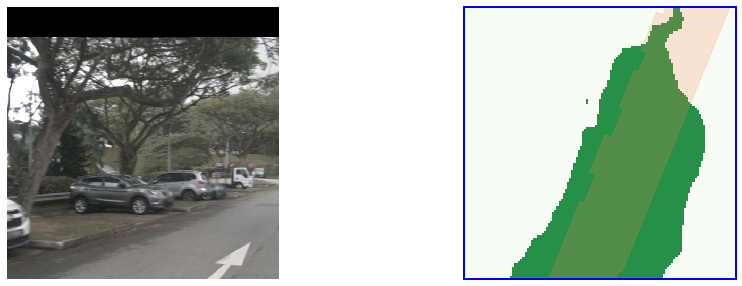

Single inference took 0.006 sec on input tensor size torch.Size([1, 3, 512, 512])


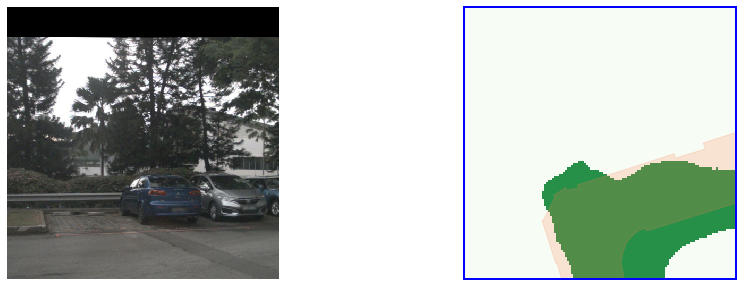

Single inference took 0.006 sec on input tensor size torch.Size([1, 3, 512, 512])


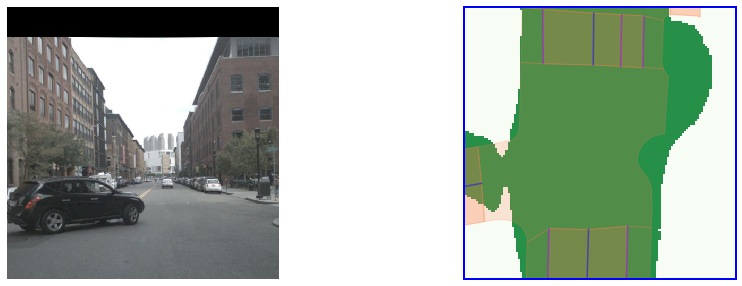

Single inference took 0.008 sec on input tensor size torch.Size([1, 3, 512, 512])


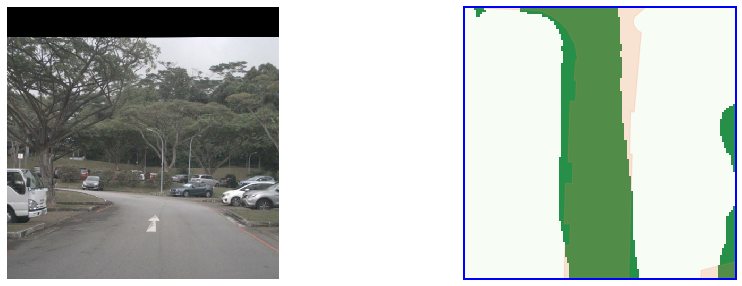

Single inference took 0.008 sec on input tensor size torch.Size([1, 3, 512, 512])


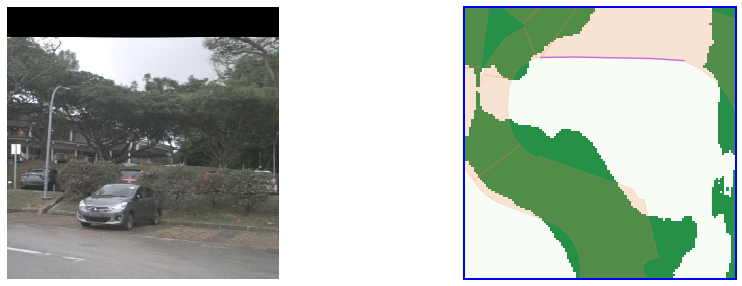

Average FPS: 146.80746016555776 Hz


In [10]:
from time import time
import sys
sys.path.append('../lift-splat-shoot/')
from src.tools import plot_nusc_map, gen_dx_bx
%matplotlib inline

data = valdata

scene2map = {}
for scene in nusc.scene:
    log = nusc.get('log', scene['log_token'])
    scene2map[scene['name']] = log['location']
    
dx, bx, _ = gen_dx_bx(grid_conf['xbound'], grid_conf['ybound'], grid_conf['zbound'])
dx, bx = dx[:2].numpy(), bx[:2].numpy()

FPS = []
with torch.no_grad():
    torch.manual_seed(13)
    for counter in np.random.choice(range(len(data)), 5):
        img, _, _, _, _, _, map_binimg = data[counter]

        # inference
        input_image = img.to(device)
        t0 = time()
        features = models["encoder"](input_image)
        tv = models["decoder"](features, is_training=False)
        
        dt = time() - t0
        print(f'Single inference took {dt:.3f} sec on input tensor size {img.size()}')
        FPS.append(1./dt)
        
        local_map = pred_to_vis(tv)

        fig = plt.figure(figsize=(15, 5))

        plt.clf()
        ax = plt.subplot(1, 2, 1)
        showimg = denormalize_img(img.squeeze(0))
        plt.imshow(showimg)
        plt.axis('off')

        ax = plt.subplot(1, 2, 2)
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        plt.setp(ax.spines.values(), color='b', linewidth=2)

        plot_nusc_map(data.ixes[counter], nusc_maps, nusc, scene2map, dx, bx)
        plt.imshow(local_map, cmap='Greens', vmin=0, vmax=350)
        plt.xlim((data.nx[0], 0))
        plt.ylim((0, data.nx[1]))

        plt.show()
        
print(f'Average FPS: {np.mean(FPS[1:])} Hz')

### Custom video data

  0%|          | 0/100000 [00:00<?, ?it/s]

[INFO] 505800 total frames in video


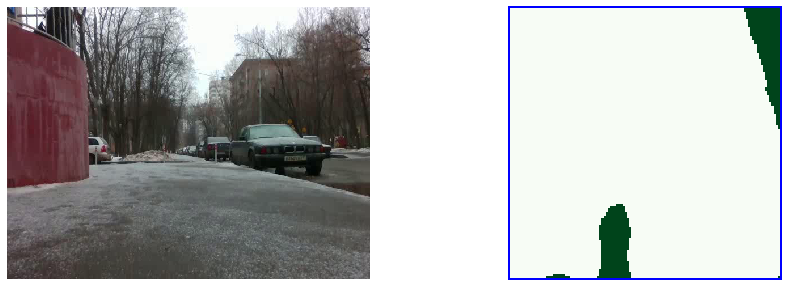

 10%|▉         | 9825/100000 [00:05<00:49, 1833.90it/s]

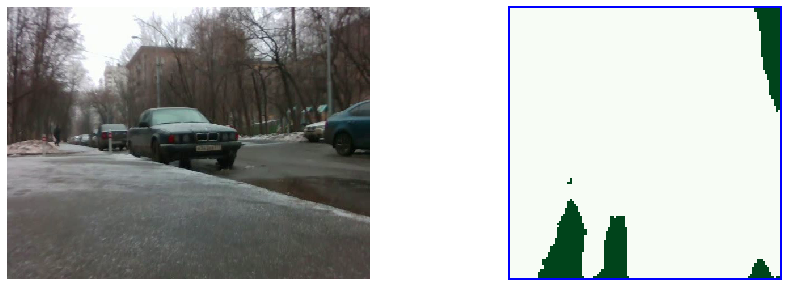

 20%|█▉        | 19980/100000 [00:12<00:42, 1863.77it/s]

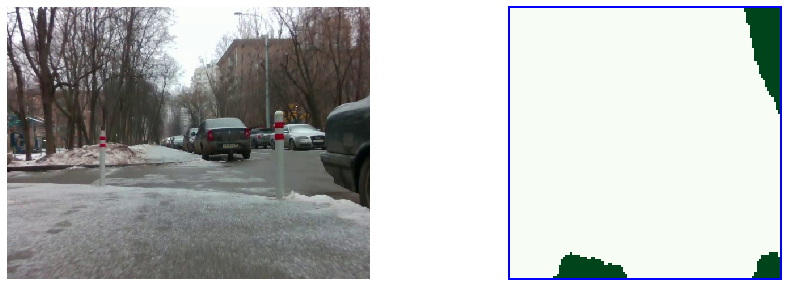

 30%|██▉       | 29904/100000 [00:17<00:36, 1927.80it/s]

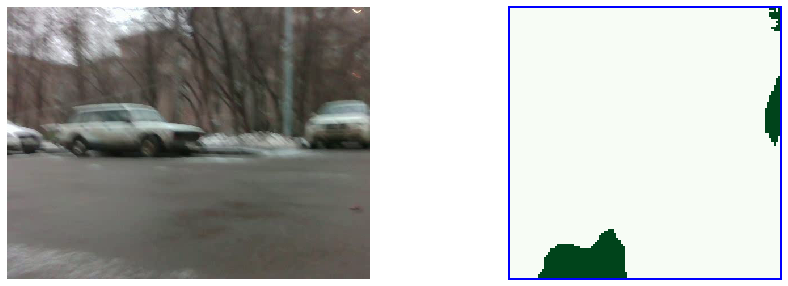

 40%|███▉      | 39863/100000 [00:23<00:33, 1821.26it/s]

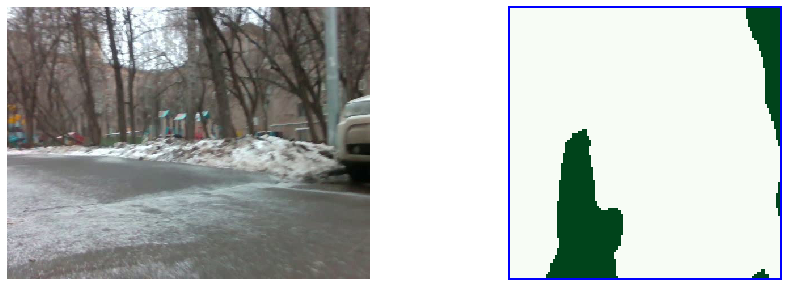

 50%|████▉     | 49816/100000 [00:29<00:26, 1877.55it/s]

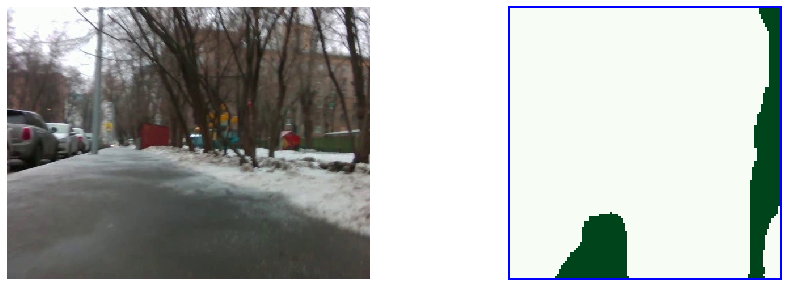

 60%|█████▉    | 59843/100000 [00:35<00:21, 1852.71it/s]

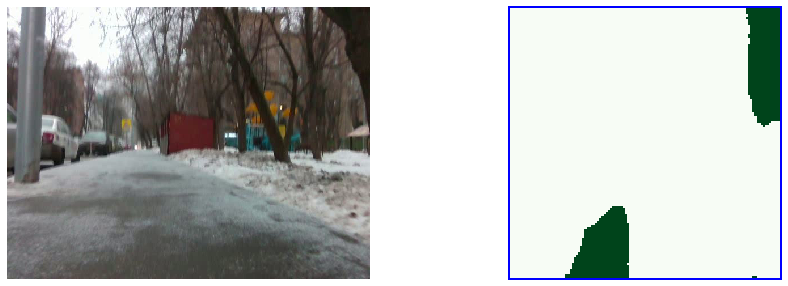

 70%|██████▉   | 69953/100000 [00:40<00:16, 1851.77it/s]

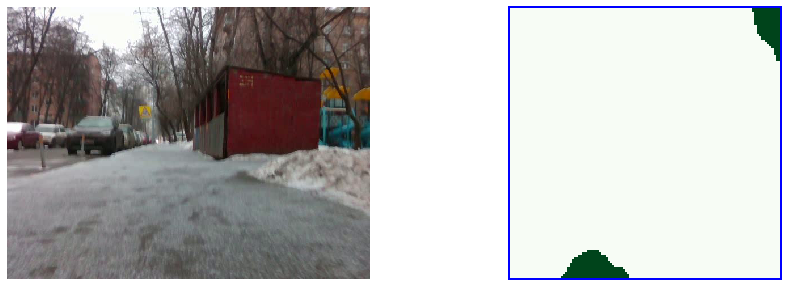

 80%|███████▉  | 79905/100000 [00:46<00:11, 1762.97it/s]

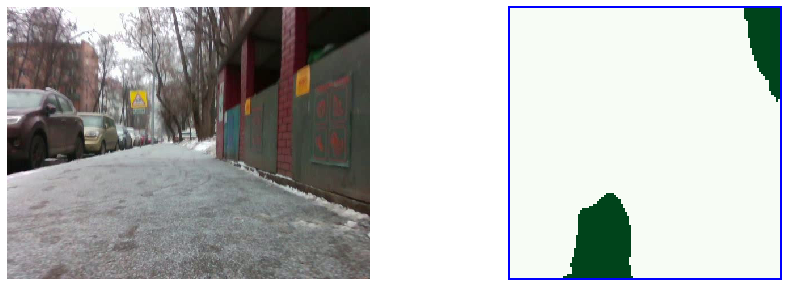

 90%|████████▉ | 89835/100000 [00:52<00:06, 1603.00it/s]

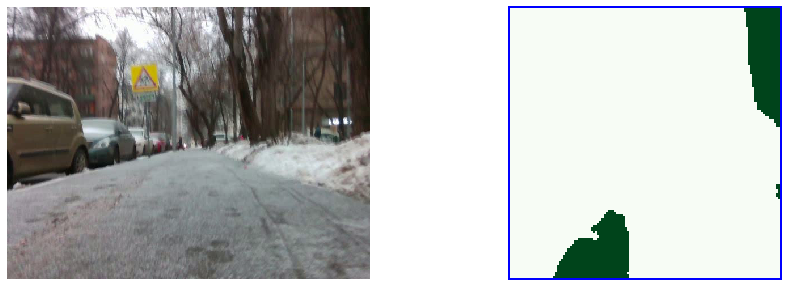

100%|██████████| 100000/100000 [00:59<00:00, 1693.53it/s]


In [12]:
import imutils
from tqdm import tqdm

vs = cv2.VideoCapture('/home/ruslan/Desktop/DoEdu/data/videos/dundich_raw.avi')
writer = None

# try to determine the total number of frames in the video file
try:
    prop =  cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    total = -1

feed_width, feed_height = 512, 512
FPS = []
with torch.no_grad():
    
    # while(1):
    for i in tqdm( range(100000) ):
        # get raw frames from video stream
        ret, frame_raw = vs.read()
        if ret == False:
            break
        
        if i % 10000 == 0:
            # preprocess raw frames
            frame = cv2.cvtColor(frame_raw, cv2.COLOR_BGR2RGB)
            input_image = pil.fromarray(frame)

            input_image = input_image.resize(
                (feed_width, feed_height), pil.LANCZOS)
            input_image = transforms.ToTensor()(input_image).unsqueeze(0)

            # predict segmentation mask from the frame
            input_image = input_image.to(device)
            features = models["encoder"](input_image)
            tv = models["decoder"](features, is_training=False)
            
            local_map = pred_to_vis(tv)

            fig = plt.figure(figsize=(15, 5))

            plt.clf()
            ax = plt.subplot(1, 2, 1)
            plt.imshow(frame)
            plt.axis('off')

            ax = plt.subplot(1, 2, 2)
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.setp(ax.spines.values(), color='b', linewidth=2)

            plt.imshow(local_map, cmap='Greens')
            plt.xlim((data.nx[0], 0))
            plt.ylim((0, data.nx[1]))

            plt.show()

### Discriminator

In [11]:
models["discriminator"] = model.Discriminator()
discriminator_path = os.path.join(model_path, "discriminator.pth")

models["discriminator"].load_state_dict(
    torch.load(discriminator_path, map_location=device))

for key in models.keys():
    models[key].to(device)
    models[key].eval()

In [12]:
models['discriminator']

Discriminator(
  (main): Sequential(
    (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [13]:
data = valdata

with torch.no_grad():
    for counter in np.random.choice(range(len(data)), 5):
        img, _, _, _, _, _, map_binimg = data[counter]

        features = models["encoder"](img.to(device))
        pred = models["decoder"](features, is_training=False)

        real_pred = models['discriminator'](map_binimg.unsqueeze(0).to(device))
        fake_pred = models["discriminator"](pred)

In [14]:
fake_pred

tensor([[[[0.9998, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]]],
       device='cuda:0')

In [15]:
real_pred

tensor([[[[0.9989, 0.9999, 0.9996, 0.9999, 0.9999, 1.0000, 0.9998, 0.9943],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
          [0.9962, 0.9998, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999]]]],
       device='cuda:0')

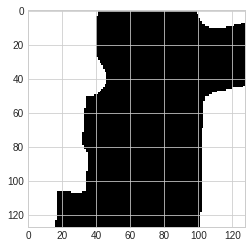

In [30]:
plt.imshow(map_binimg[0])

In [27]:
pred.size()

torch.Size([1, 2, 128, 128])

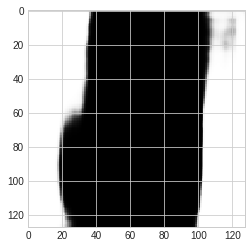

In [31]:
plt.imshow(pred.squeeze(0)[1].cpu())